In [1]:
# Célula 1: Configuração do Ambiente
!pip install -U scikit-learn pandas matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")
RANDOM_STATE = 42
TEST_SIZE = 0.30

print("Ambiente configurado com sucesso!")

Ambiente configurado com sucesso!


In [2]:
# Célula 2: Carregar o Seeds Dataset
COLUMN_NAMES = [
    "area", "perimeter", "compactness",
    "length_kernel", "width_kernel",
    "asymmetry_coeff", "length_kernel_groove",
    "class"
]

def load_seeds(filepath: str) -> pd.DataFrame:
    """Lê o Seeds Dataset tratando espaços irregulares e garantindo
    tipagem numérica com imputação mediana."""
    try:
        df = pd.read_csv(filepath, sep=r"\s+", header=None, engine="python")
    except Exception:
        rows = []
        with open(filepath, "r") as f:
            for line in f:
                parts = [p for p in line.strip().split() if p != ""]
                if len(parts) == 8:
                    rows.append(parts)
        df = pd.DataFrame(rows)

    df.columns = COLUMN_NAMES

    for col in COLUMN_NAMES:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=["class"]).copy()
    df["class"] = df["class"].astype(int)

    feature_cols = COLUMN_NAMES[:-1]
    imputer = SimpleImputer(strategy="median")
    df[feature_cols] = imputer.fit_transform(df[feature_cols])

    return df

df = load_seeds("seeds_dataset.txt")
print("Dataset carregado!")
display(df.head())
display(df["class"].value_counts())

Dataset carregado!


,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


,count
class,
1,70
2,70
3,70


Análise Exploratória (CRISP-DM — Compreensão dos Dados)

Estatísticas Descritivas:


,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coeff,length_kernel_groove,class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000



Valores ausentes por coluna:
area                    0
perimeter               0
compactness             0
length_kernel           0
width_kernel            0
asymmetry_coeff         0
length_kernel_groove    0
class                   0
dtype: int64


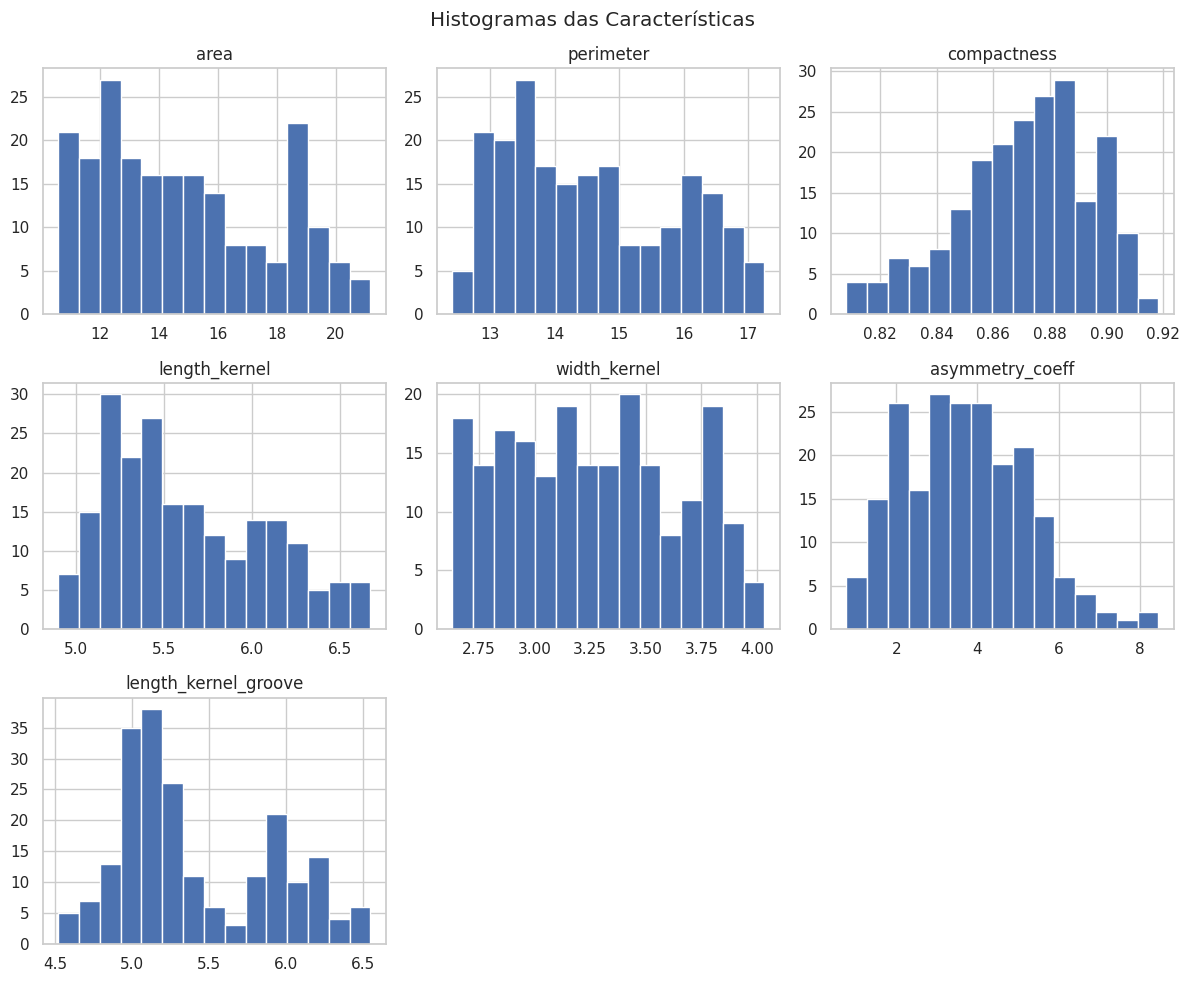

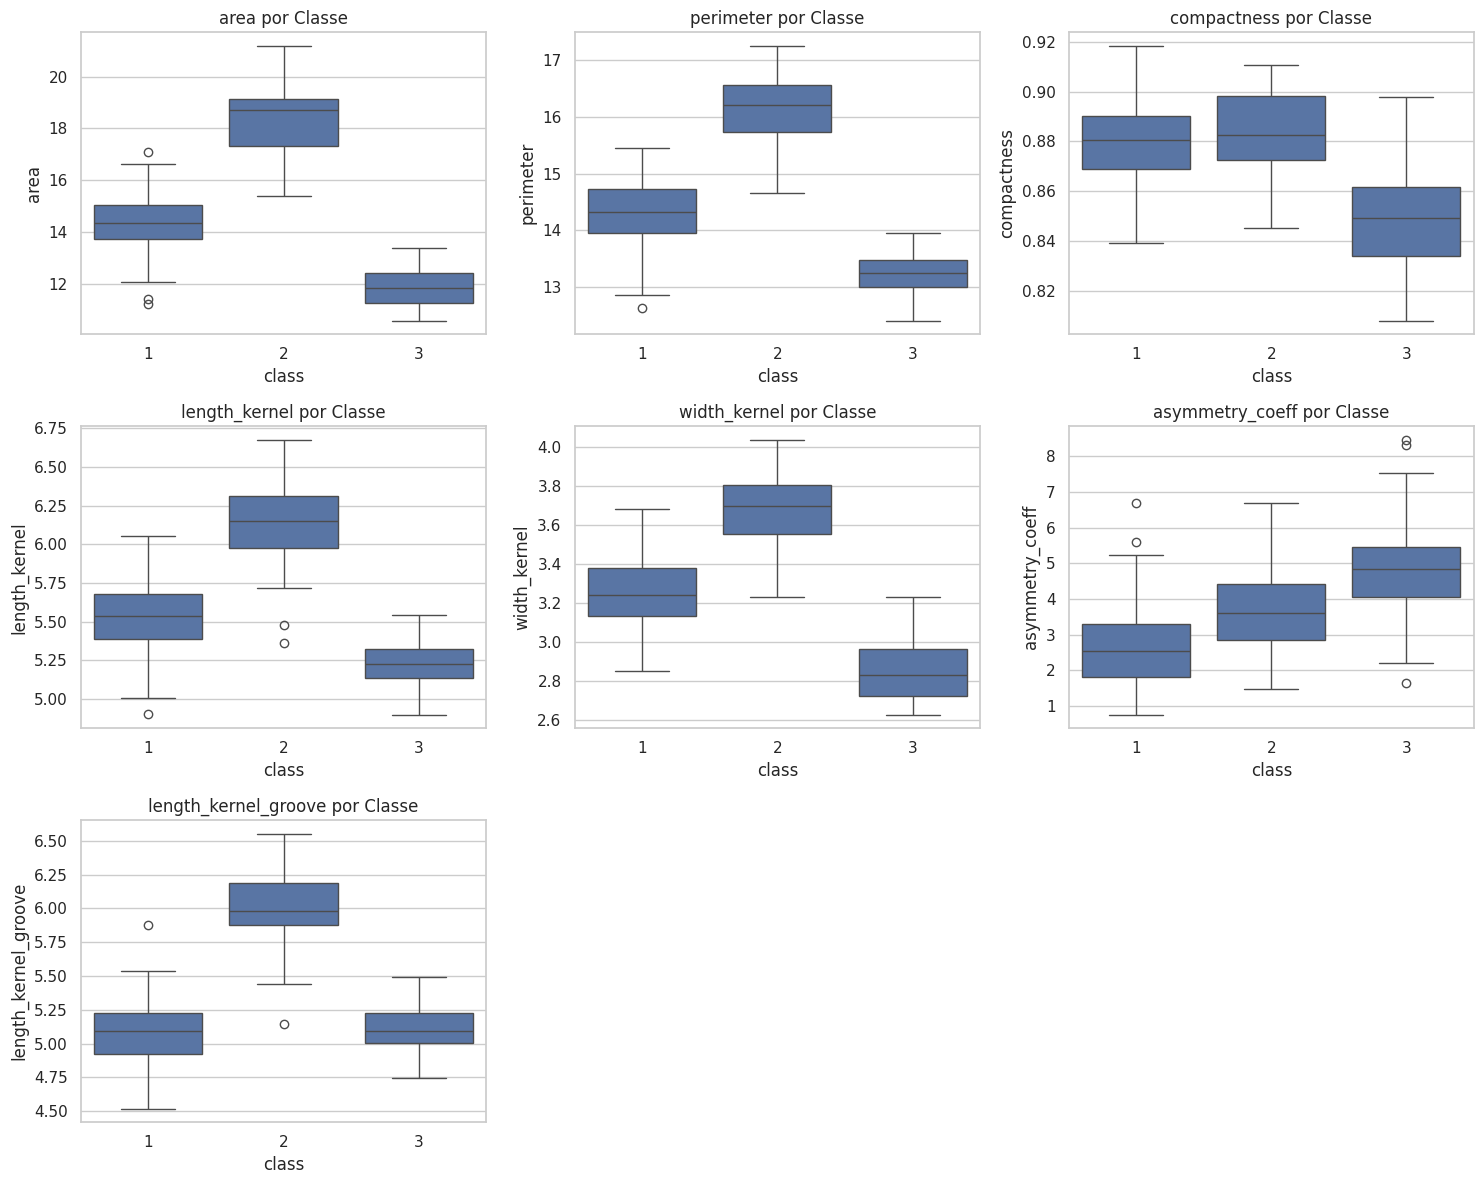

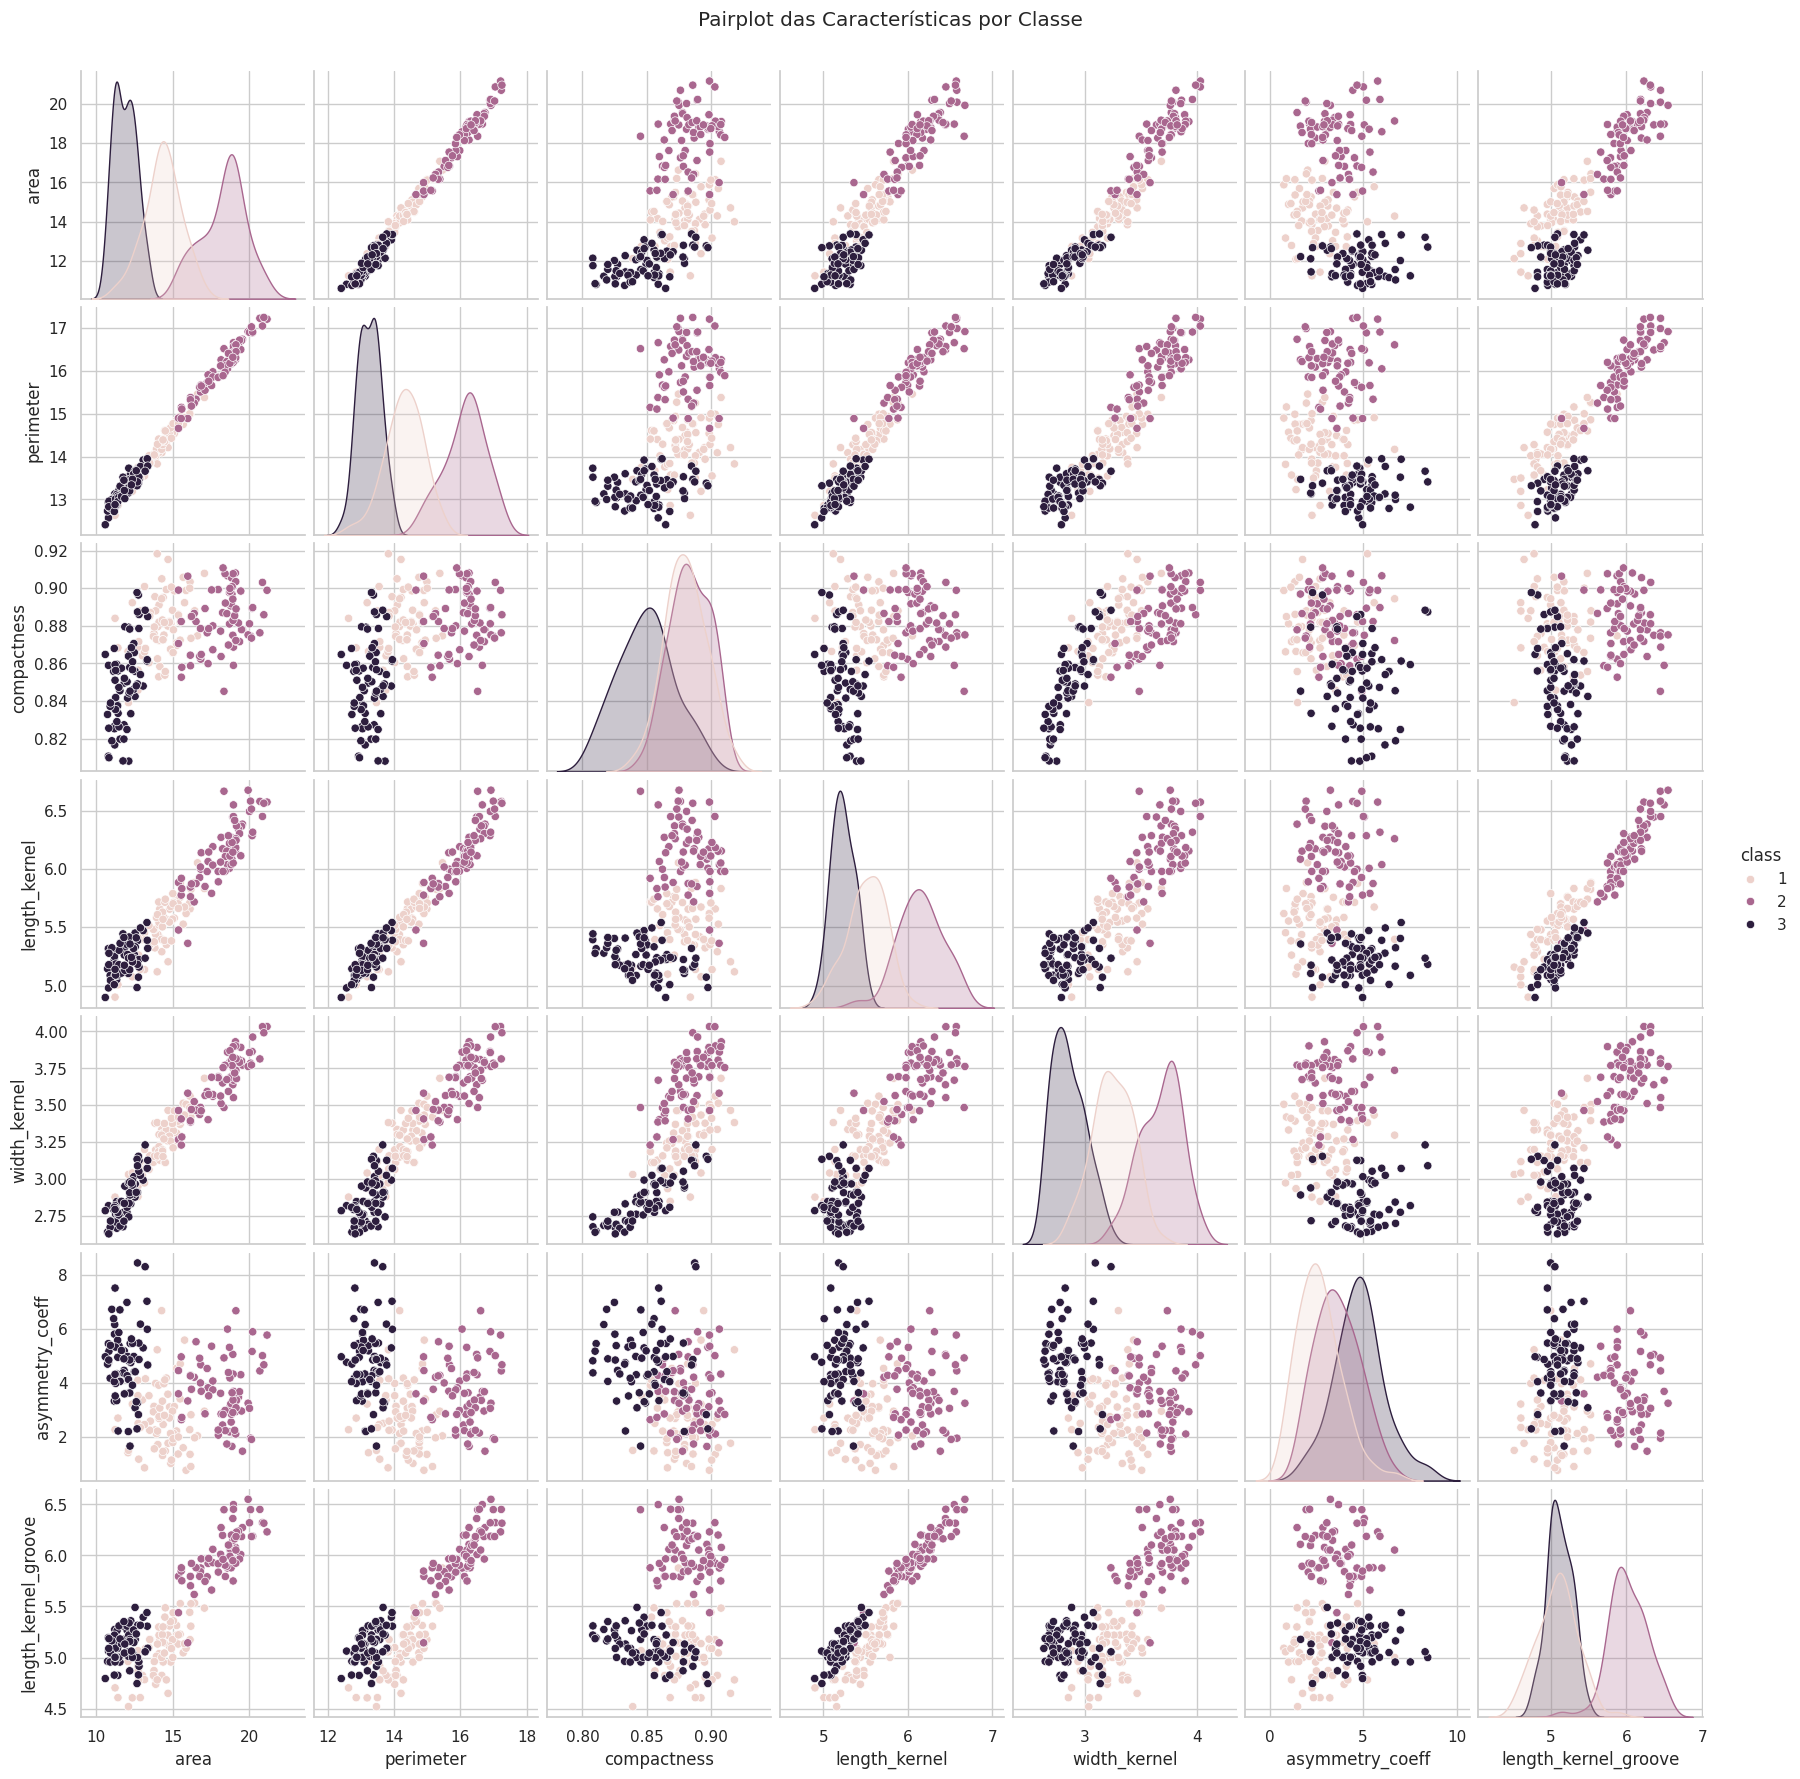

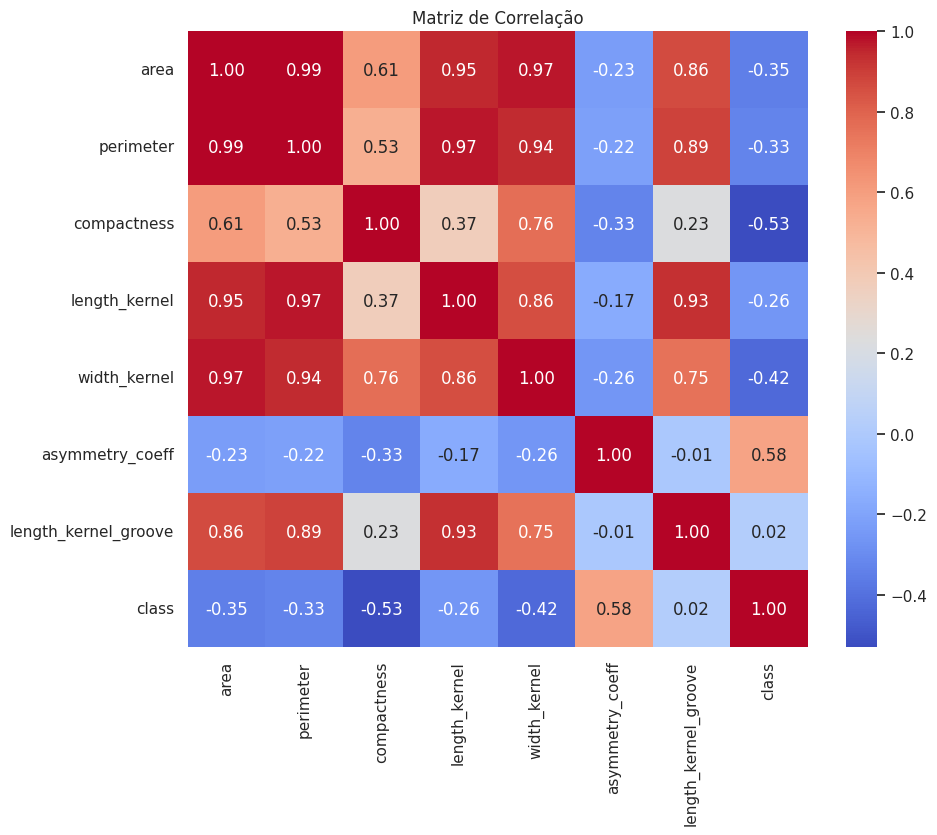

In [3]:
# Célula 3: Estatísticas, histogramas, boxplots e correlação
print("Estatísticas Descritivas:")
display(df.describe())

print("\nValores ausentes por coluna:")
print(df.isnull().sum())

df.drop(columns=["class"]).hist(bins=15, figsize=(12, 10), layout=(3, 3))
plt.suptitle("Histogramas das Características")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x="class", y=col, data=df)
    plt.title(f"{col} por Classe")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue="class", diag_kind="kde")
plt.suptitle("Pairplot das Características por Classe", y=1.02)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Preparação dos Dados e Modelos Base (CRISP-DM — Preparação & Modelagem)

In [4]:
# Célula 4: Divisão treino/teste e treinamento dos modelos baseline
X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=RANDOM_STATE, probability=True),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "NaiveBayes": GaussianNB()
}

results_baseline = []

print("--- Resultados Baseline (sem tuning) ---")
for name, clf in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results_baseline.append({
        "Modelo": name,
        "Acurácia": report["accuracy"],
        "F1-Weighted": report["weighted avg"]["f1-score"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"]
    })
    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred, zero_division=0))

results_baseline = pd.DataFrame(results_baseline).sort_values(by="Acurácia", ascending=False)
display(results_baseline)

--- Resultados Baseline (sem tuning) ---

Modelo: KNN
              precision    recall  f1-score   support

           1       0.84      0.76      0.80        21
           2       0.90      0.90      0.90        21
           3       0.87      0.95      0.91        21

    accuracy                           0.87        63
   macro avg       0.87      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63


Modelo: SVM
              precision    recall  f1-score   support

           1       0.84      0.76      0.80        21
           2       0.90      0.90      0.90        21
           3       0.87      0.95      0.91        21

    accuracy                           0.87        63
   macro avg       0.87      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63


Modelo: RandomForest
              precision    recall  f1-score   support

           1       0.94      0.81      0.87        21
           2       0.95      0.95      0

,Modelo,Acurácia,F1-Weighted,Precisão,Recall
2,RandomForest,0.920635,0.919170,0.923942,0.920635
0,KNN,0.873016,0.871284,0.872144,0.873016
1,SVM,0.873016,0.871284,0.872144,0.873016
3,NaiveBayes,0.825397,0.825060,0.833928,0.825397


Otimização de Hiperparâmetros (CRISP-DM — Modelagem Refinada)


Otimizando KNN...
Melhores parâmetros: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'uniform'}
              precision    recall  f1-score   support

           1       0.85      0.81      0.83        21
           2       0.90      0.90      0.90        21
           3       0.91      0.95      0.93        21

    accuracy                           0.89        63
   macro avg       0.89      0.89      0.89        63
weighted avg       0.89      0.89      0.89        63



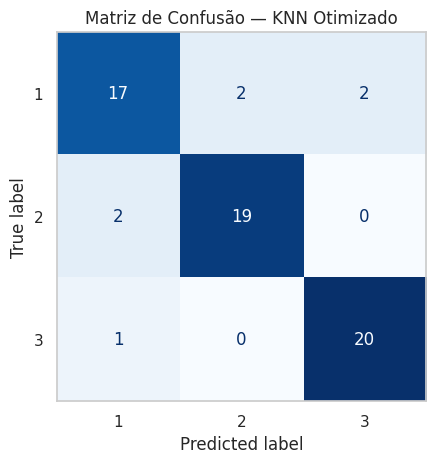


Otimizando SVM...
Melhores parâmetros: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.85      0.81      0.83        21
           2       0.95      0.86      0.90        21
           3       0.88      1.00      0.93        21

    accuracy                           0.89        63
   macro avg       0.89      0.89      0.89        63
weighted avg       0.89      0.89      0.89        63



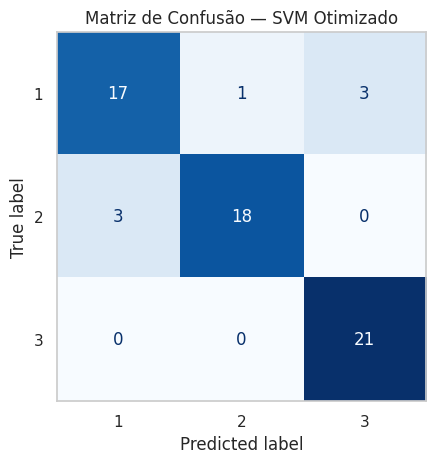


Otimizando RandomForest...
Melhores parâmetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
              precision    recall  f1-score   support

           1       0.94      0.81      0.87        21
           2       0.95      0.95      0.95        21
           3       0.88      1.00      0.93        21

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63



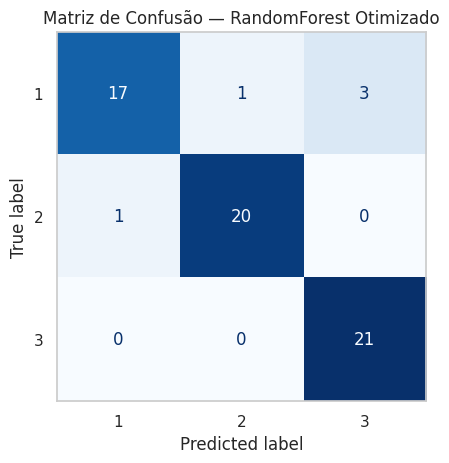

,Modelo,Acurácia,F1-Weighted,Precisão,Recall
0,KNN (Tuned),0.888889,0.888088,0.887951,0.888889
1,SVM (Tuned),0.888889,0.887534,0.890789,0.888889
2,RandomForest (Tuned),0.920635,0.919170,0.923942,0.920635


In [5]:
# Célula 5: GridSearch para KNN, SVM e Random Forest
param_grids = {
    "KNN": (
        Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier())]),
        {
            "model__n_neighbors": [3, 5, 7, 9, 11],
            "model__weights": ["uniform", "distance"],
            "model__metric": ["euclidean", "manhattan"]
        }
    ),
    "SVM": (
        Pipeline([("scaler", StandardScaler()), ("model", SVC(random_state=RANDOM_STATE))]),
        {
            "model__C": [0.1, 1, 10, 100],
            "model__gamma": ["scale", "auto", 0.1, 1],
            "model__kernel": ["rbf", "linear"]
        }
    ),
    "RandomForest": (
        Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier(random_state=RANDOM_STATE))]),
        {
            "model__n_estimators": [100, 200, 300],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    )
}

results_tuned = []

for name, (pipeline, params) in param_grids.items():
    print(f"\nOtimizando {name}...")
    grid = GridSearchCV(pipeline, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Melhores parâmetros: {grid.best_params_}")
    y_pred = grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results_tuned.append({
        "Modelo": f"{name} (Tuned)",
        "Acurácia": report["accuracy"],
        "F1-Weighted": report["weighted avg"]["f1-score"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"]
    })
    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, colorbar=False)
    plt.title(f"Matriz de Confusão — {name} Otimizado")
    plt.grid(False)
    plt.show()

results_tuned = pd.DataFrame(results_tuned)
display(results_tuned)

In [6]:
# Célula 6: Comparação baseline vs tuned
comparativo = pd.concat([results_baseline.assign(Status="Baseline"),
                         results_tuned.assign(Status="Tuned")])
display(comparativo.sort_values(by="Acurácia", ascending=False))

,Modelo,Acurácia,F1-Weighted,Precisão,Recall,Status
2,RandomForest,0.920635,0.919170,0.923942,0.920635,Baseline
2,RandomForest (Tuned),0.920635,0.919170,0.923942,0.920635,Tuned
0,KNN (Tuned),0.888889,0.888088,0.887951,0.888889,Tuned
1,SVM (Tuned),0.888889,0.887534,0.890789,0.888889,Tuned
0,KNN,0.873016,0.871284,0.872144,0.873016,Baseline
1,SVM,0.873016,0.871284,0.872144,0.873016,Baseline
3,NaiveBayes,0.825397,0.825060,0.833928,0.825397,Baseline
